# Experimenting with RNA expression scaling

In [1]:
from pathlib import Path

import janitor  # noqa: F401
import numpy as np
import pandas as pd
import plotnine as gg
from tqdm import tqdm

In [2]:
_ = gg.theme_set(gg.theme_bw())
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 78934

## Loading data

In [3]:
modeling_data_dir = Path("..", "..", "modeling_data")

crc_df_path = modeling_data_dir / "depmap_modeling_dataframe_crc.csv"
assert crc_df_path.exists()

full_modeling_data_path = modeling_data_dir / "depmap_modeling_dataframe.csv"
assert full_modeling_data_path.exists()

In [4]:
ovary_df = pd.DataFrame()

chunked_modeling_data = pd.read_csv(
    full_modeling_data_path,
    iterator=True,
    chunksize=1000000,
    low_memory=False,
)

for chunk in tqdm(chunked_modeling_data):
    ovary_chunk = chunk.query("lineage == 'ovary'")

    if chunk.shape[0] > 0:
        ovary_df = pd.concat([ovary_df, ovary_chunk])

89it [08:34,  5.79s/it]


In [5]:
ovary_df = ovary_df.reset_index(drop=True)

In [6]:
ovary_df.head()

,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,AAACCTGCGGCGGTCGCCA,OVR3_c905R1,-0.299958,CRISPR_C6596666.sample,chr8_66505451_-,VXN,sanger,True,8,66505451,...,0,NaN,NaN,NaN,False,0.847995,ovary,metastasis,False,60.0
1,AACAGCACACCGGCCCCGT,OVR3_c905R1,0.267092,CRISPR_C6596666.sample,chrX_156009834_-,IL9R,sanger,True,X,156009834,...,0,NaN,NaN,NaN,False,0.700605,ovary,metastasis,False,60.0
2,AACCTCCGGACTCCTCAGC,OVR3_c905R1,0.550477,CRISPR_C6596666.sample,chr7_39609658_-,YAE1,sanger,True,7,39609658,...,0,NaN,NaN,NaN,False,0.934918,ovary,metastasis,False,60.0
3,AACTCAAACTGACGCCGAA,OVR3_c905R1,-0.391922,CRISPR_C6596666.sample,chr1_117623388_-,TENT5C,sanger,True,1,117623388,...,0,NaN,NaN,NaN,False,1.352975,ovary,metastasis,False,60.0
4,AACTGACCTTGAAACGCTG,OVR3_c905R1,-1.562577,CRISPR_C6596666.sample,chr16_66933623_+,CIAO2B,sanger,True,16,66933623,...,0,NaN,NaN,NaN,False,1.259171,ovary,metastasis,False,60.0


In [7]:
ovary_df.shape

(5784486, 22)

In [8]:
crc_df = pd.read_csv(crc_df_path, low_memory=False)
print(crc_df.shape)
crc_df.head()

(5460544, 22)


,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,num_mutations,any_deleterious,any_tcga_hotspot,any_cosmic_hotspot,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age
0,AAACCTGCGGCGGTCGCCA,LS513_c903R1,0.563383,ERS717283.plasmid,chr8_66505451_-,VXN,sanger,True,8,66505451,...,0,NaN,NaN,NaN,False,0.956651,colorectal,primary,True,63.0
1,AAAGCCCAGGAGTATGGGAG,LS513-311Cas9_RepA_p6_batch2,0.594321,2,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,0,NaN,NaN,NaN,False,0.953860,colorectal,primary,True,63.0
2,AAATCAGAGAAACCTGAACG,LS513-311Cas9_RepA_p6_batch2,-0.363633,2,chr11_89916950_-,TRIM49D1,broad,True,11,89916950,...,0,NaN,NaN,NaN,False,0.960466,colorectal,primary,True,63.0
3,AACAGCACACCGGCCCCGT,LS513_c903R1,-0.512694,ERS717283.plasmid,chrX_156009834_-,IL9R,sanger,True,X,156009834,...,0,NaN,NaN,NaN,False,0.478776,colorectal,primary,True,63.0
4,AACCTCCGGACTCCTCAGC,LS513_c903R1,-0.075108,ERS717283.plasmid,chr7_39609658_-,YAE1,sanger,True,7,39609658,...,0,NaN,NaN,NaN,False,1.437966,colorectal,primary,True,63.0


## Testing RNA expression scaling

In [9]:
np.random.seed(RANDOM_SEED)
test_genes = np.random.choice(crc_df.hugo_symbol.unique(), size=50, replace=False)

In [10]:
df = (
    pd.concat([ovary_df, crc_df])
    .reset_index()
    .filter_column_isin(column_name="hugo_symbol", iterable=test_genes)
)

df.shape

(31945, 23)

In [11]:
df_rna = df[["lineage", "depmap_id", "hugo_symbol", "rna_expr"]].drop_duplicates()
df_rna.shape

(5524, 4)

In [12]:
df_rna[df_rna["rna_expr"].isna()]

,lineage,depmap_id,hugo_symbol,rna_expr


In [13]:
def plot_by_lineage(df: pd.DataFrame, y: str = "rna_expr") -> gg.ggplot:
    return (
        gg.ggplot(df, gg.aes(x="hugo_symbol", y=y))
        + gg.geom_point(gg.aes(color="lineage"), size=0.2, alpha=0.2)
        + gg.geom_boxplot(
            gg.aes(color="lineage", fill="lineage"), alpha=0.2, outlier_alpha=0.0
        )
        + gg.scale_y_continuous(expand=(0.02, 0, 0.02, 0))
        + gg.theme(
            axis_text_x=gg.element_text(angle=90, size=7),
            axis_ticks=gg.element_blank(),
            figure_size=(10, 3),
            legend_position="top",
        )
        + gg.labs(x="gene")
    )

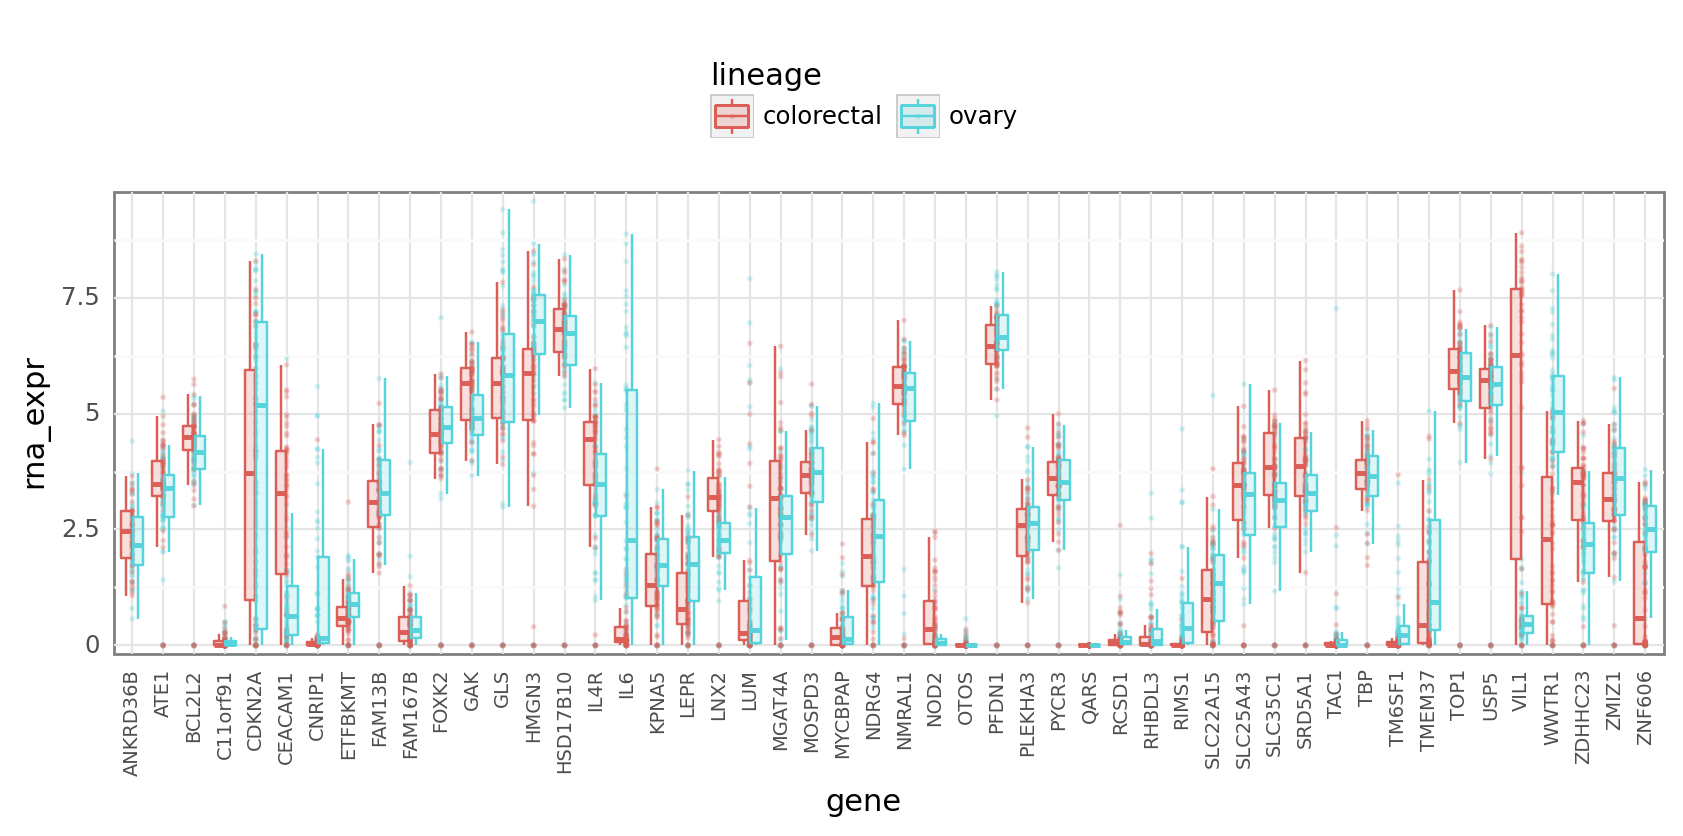

<ggplot: (8732187872380)>

In [14]:
plot_by_lineage(df_rna)

In [15]:
np.log10(1)

0.0

In [16]:
def zscale(x: np.ndarray) -> np.ndarray:
    # print(args)
    return (x - np.mean(x)) / np.std(x)


def squish(x: float, lower: float, upper: float) -> float:
    return max(min(x, upper), lower)


squish_array = np.vectorize(squish)


def rna_zscale(df: pd.DataFrame) -> pd.DataFrame:
    rna = df["rna_expr"].values

    if np.allclose(rna, 0.0):
        df["rna_expr_z"] = np.log10(rna + 1)
    else:
        df["rna_expr_z"] = squish_array(
            zscale(np.log10(rna + 1)), lower=-2.0, upper=2.0
        )

    return df

In [17]:
df_rna = df_rna.groupby(["lineage", "hugo_symbol"]).apply(rna_zscale)

In [18]:
df_rna[np.isinf(df_rna["rna_expr_z"])]

,lineage,depmap_id,hugo_symbol,rna_expr,rna_expr_z


In [19]:
df_rna[df_rna["rna_expr_z"].isna()]

,lineage,depmap_id,hugo_symbol,rna_expr,rna_expr_z


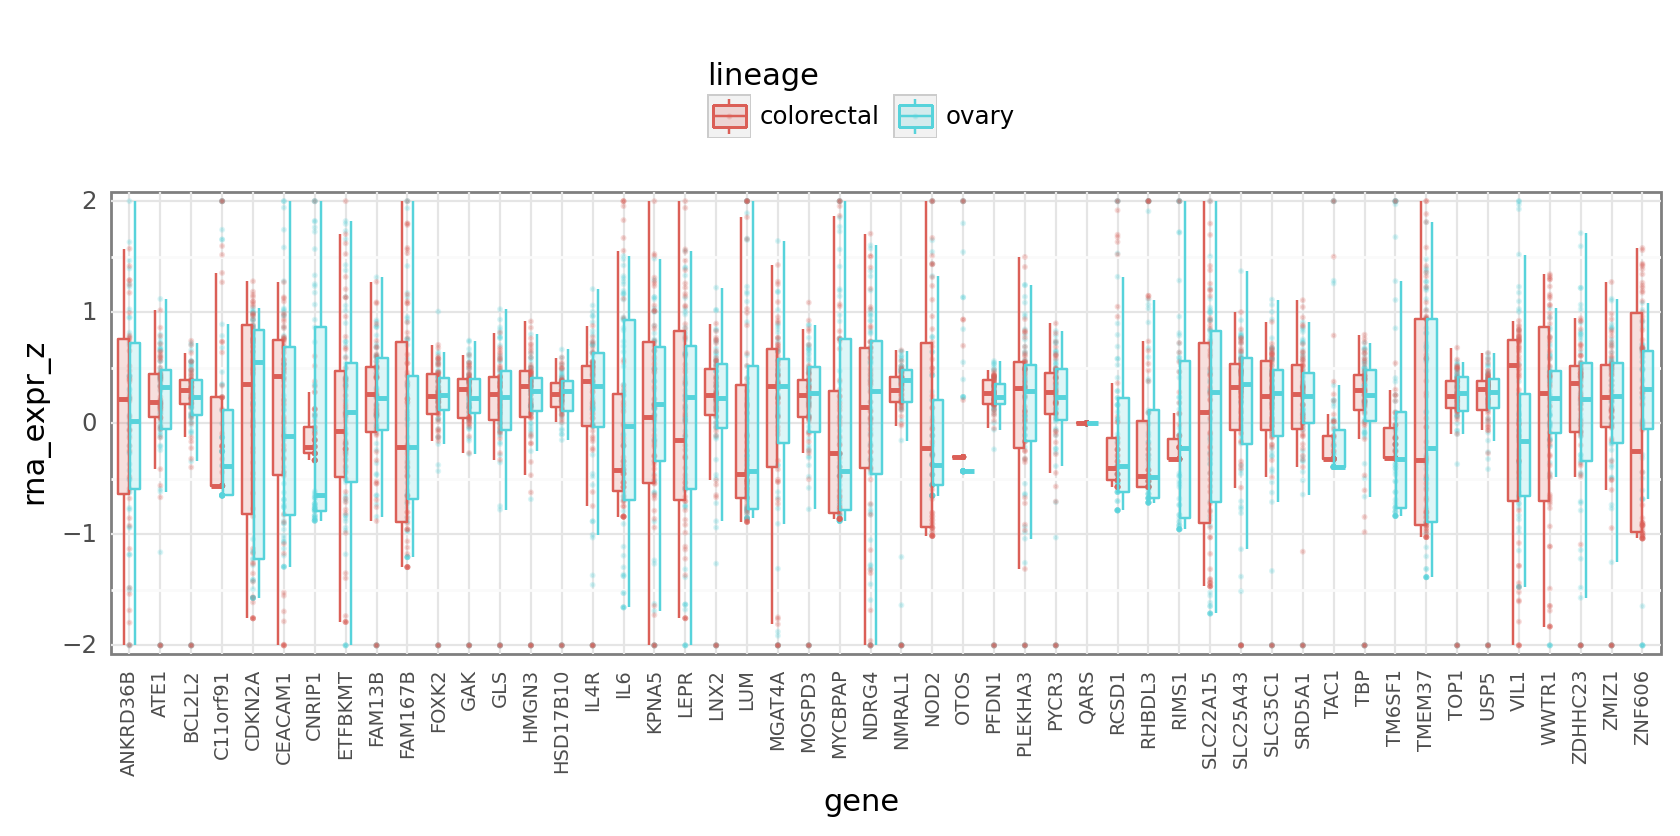

<ggplot: (8732148979670)>

In [20]:
plot_by_lineage(df_rna, y="rna_expr_z")

---

In [21]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-06-08

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.22.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: sp56

seaborn : 0.11.1
janitor : 0.20.14
plotnine: 0.8.0
pandas  : 1.2.3
numpy   : 1.20.2

